In [2]:
%config IPCompleter.use_jedi = False
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pathlib import Path

In [3]:
proj_path = Path().resolve().parent
print(proj_path)

/home/mommess/Documents/Leeds_research/ICDCS_paper/data


In [4]:
FONT_NAME = 'Arial'
FONT_SIZE = 15
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [19]:
file_2d = proj_path / "results/density2D_64_128.csv" 
file_ts = proj_path / "results/densityTS_64_128.csv"
file_large = proj_path / "results/large2D_64_128.csv"
file_largeTS = proj_path / "results/largeTS_64_128.csv"
file_batchTS = proj_path / "results/batchTS_64_128.csv"
file_scalabilityTS = proj_path / "results/scalabilityTS_64_128.csv"

In [46]:
df_2d_column_names = ['FF', 
        'FFD-Avg', 'FFD-Max', 'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum',
        'BFD-Avg', 'BFD-Max', 'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum',
        'WFD-Avg', 'WFD-Max', 'WFD-AvgExpo', 'WFD-Surrogate', 'WFD-ExtendedSum',
        'NCD-L2Norm', 'NCD-DotProduct', 'NCD-DotDivision',
        'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2',
        'SpreadWFD-Avg', 'SpreadWFD-Max', 'SpreadWFD-Surrogate',
        'FFD-Degree', 'NodeCount', 'NCD-Fitness',
       ]

df_2d_column_names_small = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'NCD-DotProduct', 
                            'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2',
                            'SpreadWFD-Avg',
                            'FFD-Degree', 'NodeCount', 'NCD-Fitness',
                           ]
#df_2d_large_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
#       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
#       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-DotProduct',
#       'FFD-Degree', 'BCD-Fitness']

df_ts_column_names = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'SpreadWFD-Avg', 'FFD-Degree']

#df_ts_large_column_names = ['FF', 'BFD-Avg', 'WFD-AvgExpo', 'FFD-Degree']

#df_scalab_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']


classes = ['arbitrary', 'normal', 'threshold']

rename_dict = {
    "FFD-Degree": "Medea-TP",
    "NodeCount": "Medea-NC",
    "NCD-Fitness": "LRASched-Fitness",
    "NCD-DotDivision": "NCD-ThighFill",
    "FFD-AvgExpo": "FFD-AvgExp",
    "BFD-AvgExpo": "BFD-AvgExp",
    "WFD-AvgExpo": "WFD-AvgExp",
}

In [22]:
## sub_df = any one in df_2d, df_ts, df_large
def get_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[0])
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['density'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1][1:]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = (round(sub_df[i]/sub_df['LB'] - 1, 3))*100 # *100 to get percentage value
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'density'], as_index=False).mean()
    eps_df = sub_df_grouped_avg[['class', 'density'] + epsilon_column_names]
    time_df = sub_df_grouped_avg[['class', 'density'] + time_column_names]
    return eps_df, time_df

In [23]:
## sub_df = any one in df_2d, df_ts, df_large
def get_scale_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[3])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[-1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    return sub_df_grouped_avg_eps, sub_df_grouped_avg_time

In [24]:
def plot_barchart(original_df, class_name, cols, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.2
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
               '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-',
               '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
    
    plt.xticks(x*width_class, labels, fontsize=FONT_SIZE)#,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE)#, fontweight='bold')
    # plt.axhline(1.17*max([max(alg_res[i]) for i in range(alg_num)]), linewidth=0)
    #plt.title((class_name.capitalize() + " graphs"), fontsize=FONT_SIZE, fontname=FONT_NAME)
    plt.xlabel(xlabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    if log_scale:
        plt.yscale('log')
    #plt.legend(algs, loc='upper left', bbox_to_anchor=(-0.07, -0.2), ncol=5, fancybox=True, shadow=False, fontsize=FONT_SIZE)
    plt.legend(algs, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()
    return fig


# Result-1: 2D Fixed Res Request

## 1.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [36]:
df_2d = pd.read_csv(file_2d, sep='\t')
twodim_eps, twodim_time = get_exp_results(df_2d, df_2d_column_names)
twodim_eps.columns = ['class', 'density'] + df_2d_column_names
twodim_time.columns = ['class', 'density'] + df_2d_column_names

#### The algorithm effectivenss and time consumption of the three different classes 

In [28]:
twodim_eps

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,...,NCD-DotDivision,SpreadWFD-Avg,SpreadWFD-Max,SpreadWFD-Surrogate,FFD-Degree,NodeCount,NCD-Fitness,RefineWFD-Avg-5,RefineWFD-Avg-3,RefineWFD-Avg-2
0,arbitrary,1,12.22,12.22,12.22,12.22,12.22,15.55,12.22,12.22,...,11.64,4.47,4.47,4.47,12.20,12.24,11.64,7.22,5.92,5.21
1,arbitrary,5,12.16,12.16,12.16,12.16,12.16,15.52,12.16,12.16,...,11.47,4.39,4.39,4.39,12.29,12.61,11.47,7.16,6.46,5.34
2,arbitrary,10,12.06,12.06,12.06,12.06,12.06,15.61,12.06,12.06,...,11.38,4.64,4.64,4.64,12.09,12.93,11.38,7.03,6.03,5.63
3,normal,1,12.21,12.21,12.21,12.21,12.21,15.57,12.21,12.21,...,11.57,4.21,4.21,4.21,12.21,12.20,11.57,7.21,6.21,4.80
4,normal,5,12.14,12.14,12.14,12.14,12.14,15.58,12.14,12.14,...,11.66,4.54,4.54,4.54,12.11,12.34,11.66,7.13,6.13,5.72
5,normal,10,12.03,12.03,12.03,12.03,12.03,15.62,12.03,12.03,...,11.43,4.32,4.32,4.32,12.00,12.21,11.43,7.02,6.32,5.21
6,threshold,1,12.18,12.18,12.18,12.18,12.18,15.57,12.18,12.18,...,11.58,3.64,3.64,3.64,12.33,12.35,11.58,7.18,6.18,4.37
7,threshold,5,12.09,12.09,12.09,12.09,12.09,15.77,12.09,12.09,...,11.51,6.10,6.10,6.10,12.17,12.25,11.51,8.58,7.28,6.88
8,threshold,10,11.93,11.93,11.93,11.93,11.93,16.05,11.93,11.93,...,11.37,9.68,9.68,9.68,12.12,12.12,11.37,11.93,10.72,10.52


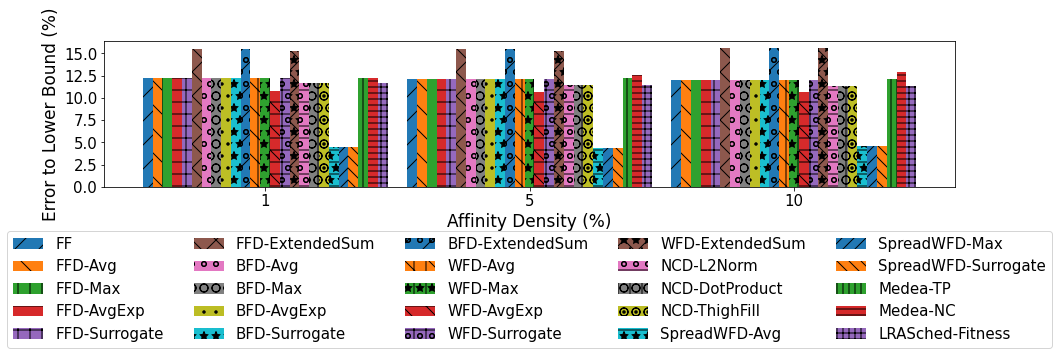

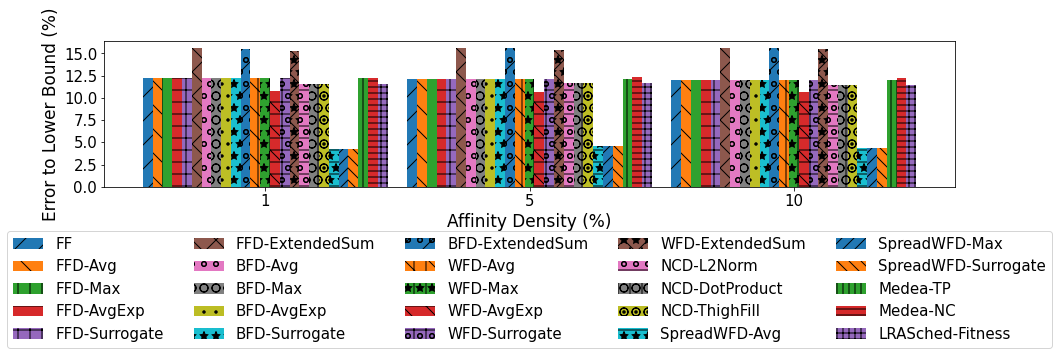

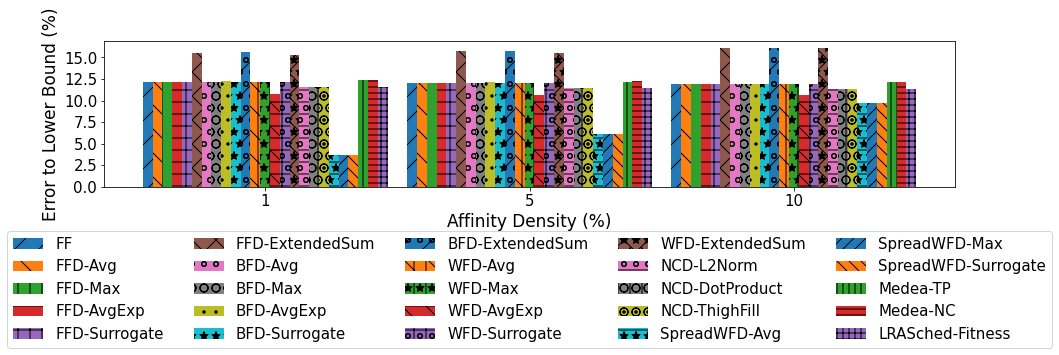

In [19]:
for c in classes:
    fig = plot_barchart(twodim_eps, c, df_2d_column_names, "Affinity Density (%)", 'Error to Lower Bound (%)')
    filename = f"{proj_path}/plots/density2D_result_{c}.pdf" 
    #fig.savefig(filename)

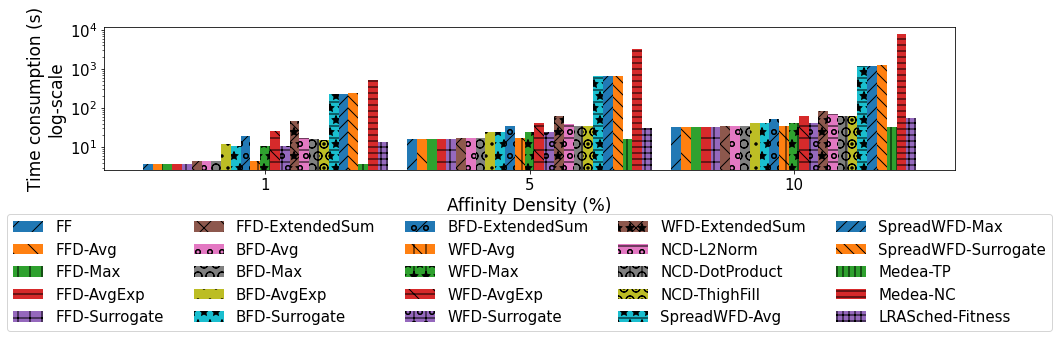

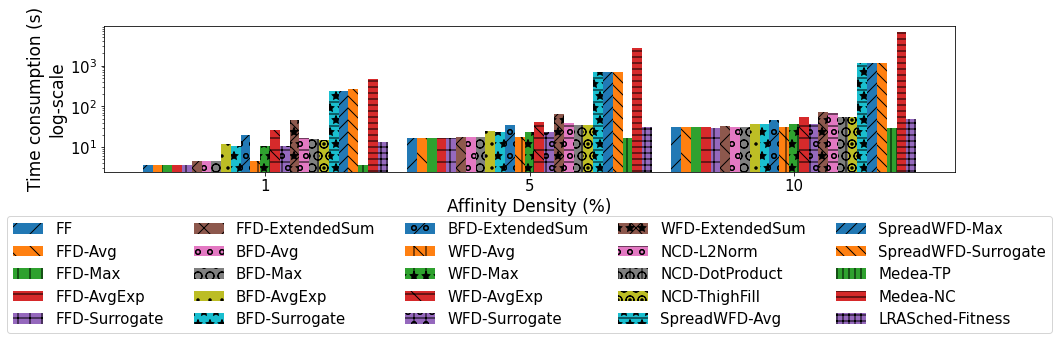

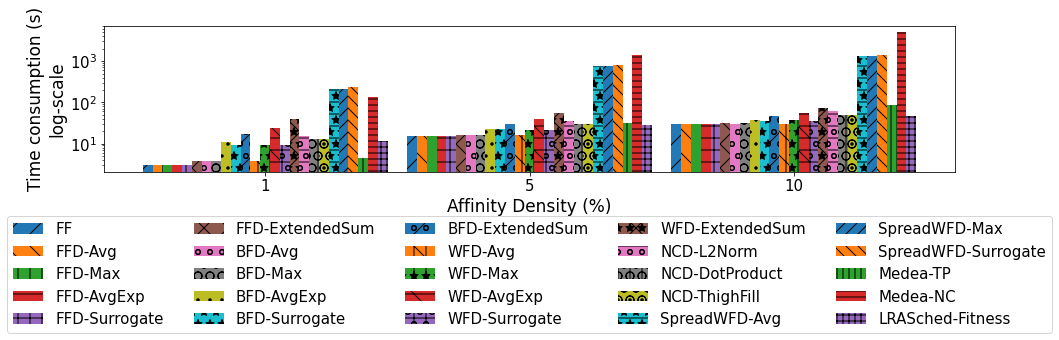

In [29]:
for c in classes: 
    fig = plot_barchart(twodim_time, c, df_2d_column_names,
                        "Affinity Density (%)",
                        'Time consumption (s)\nlog-scale', True)
#    filename = f"{proj_path}/plots/density2D_time_{c}.pdf" 
    #fig.savefig(filename)

In [28]:
twodim_time

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,...,WFD-ExtendedSum,NCD-L2Norm,NCD-DotProduct,NCD-DotDivision,SpreadWFD-Avg,SpreadWFD-Max,SpreadWFD-Surrogate,FFD-Degree,NodeCount,NCD-Fitness
0,arbitrary,1,3.7,3.7,3.7,3.7,3.7,4.5,4.5,4.5,...,47.1,17.0,15.8,15.6,225.4,226.0,248.9,3.7,512.1,13.7
1,arbitrary,5,16.4,16.2,16.2,15.9,15.8,17.4,17.3,17.4,...,62.9,38.2,34.1,33.8,652.8,657.0,673.8,16.2,3200.1,30.3
2,arbitrary,10,32.8,33.2,32.9,32.8,32.4,35.4,34.4,34.1,...,83.4,70.1,62.2,62.1,1214.6,1216.7,1245.5,32.8,8004.9,55.6
3,normal,1,3.7,3.7,3.7,3.7,3.6,4.5,4.5,4.6,...,45.9,16.9,15.4,15.3,233.6,232.9,264.9,3.6,465.5,13.4
4,normal,5,16.6,16.7,16.7,16.3,16.3,17.9,17.6,17.5,...,63.3,39.4,34.5,34.3,684.2,686.5,715.3,16.5,2674.6,30.9
5,normal,10,30.4,30.8,30.5,30.5,29.8,32.3,31.3,30.9,...,74.2,68.8,54.3,56.2,1146.4,1137.4,1149.4,30.0,6490.9,49.7
6,threshold,1,3.0,3.0,3.0,3.0,3.0,3.7,3.8,3.8,...,40.0,15.1,12.7,12.7,213.7,214.6,240.7,4.4,137.8,11.6
7,threshold,5,15.3,15.4,15.4,15.3,15.4,16.3,16.3,16.3,...,55.3,35.2,30.3,30.0,780.1,777.4,807.1,31.1,1394.0,27.8
8,threshold,10,29.8,29.7,29.7,29.6,29.7,31.3,30.7,30.8,...,71.0,60.2,49.4,50.1,1353.1,1359.4,1386.7,85.8,4929.5,46.3


### Same plots with subset of columns

In [37]:
twodim_eps_small = twodim_eps[['class', 'density'] +df_2d_column_names_small]
twodim_time_small = twodim_time[['class', 'density'] +df_2d_column_names_small]

In [38]:
twodim_eps_small

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-5,RefineWFD-Avg-3,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree,NodeCount,NCD-Fitness
0,arbitrary,1,12.22,12.22,10.75,11.64,7.22,5.92,5.21,4.47,12.20,12.24,11.64
1,arbitrary,5,12.16,12.16,10.68,11.47,7.16,6.46,5.34,4.39,12.29,12.61,11.47
2,arbitrary,10,12.06,12.06,10.71,11.38,7.03,6.03,5.63,4.64,12.09,12.93,11.38
3,normal,1,12.21,12.21,10.78,11.57,7.21,6.21,4.80,4.21,12.21,12.20,11.57
4,normal,5,12.14,12.14,10.70,11.66,7.13,6.13,5.72,4.54,12.11,12.34,11.66
5,normal,10,12.03,12.03,10.67,11.43,7.02,6.32,5.21,4.32,12.00,12.21,11.43
6,threshold,1,12.18,12.18,10.74,11.58,7.18,6.18,4.37,3.64,12.33,12.35,11.58
7,threshold,5,12.09,12.09,10.65,11.51,8.58,7.28,6.88,6.10,12.17,12.25,11.51
8,threshold,10,11.93,11.93,10.60,11.37,11.93,10.72,10.52,9.68,12.12,12.12,11.37


In [39]:
twodim_eps["FFD-ExtendedSum"].mean()

15.648888888888886

In [40]:
twodim_eps_small.mean()

density             5.333333
FF                 12.113333
BFD-Avg            12.113333
WFD-AvgExpo        10.697778
NCD-DotProduct     11.512222
RefineWFD-Avg-5     7.828889
RefineWFD-Avg-3     6.805556
RefineWFD-Avg-2     5.964444
SpreadWFD-Avg       5.110000
FFD-Degree         12.168889
NodeCount          12.361111
NCD-Fitness        11.512222
dtype: float64

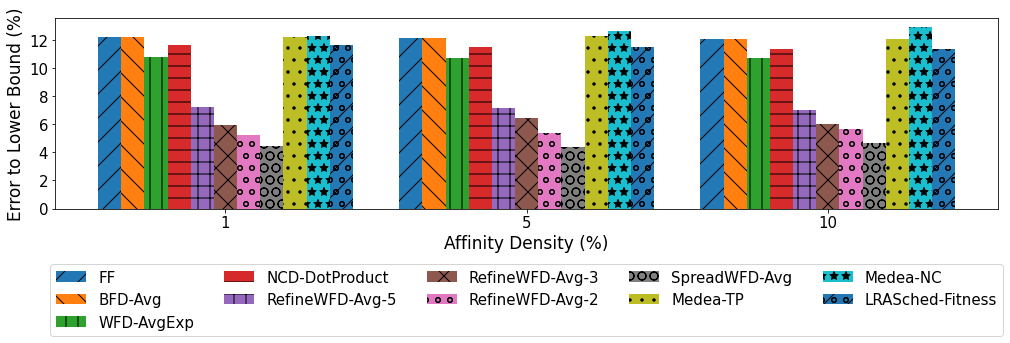

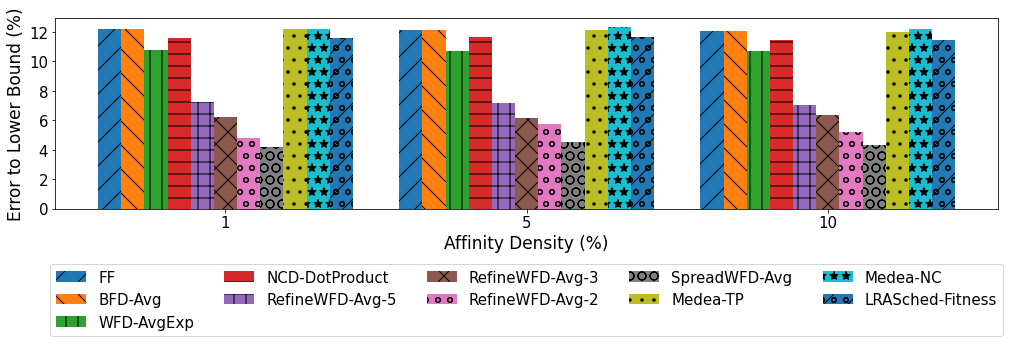

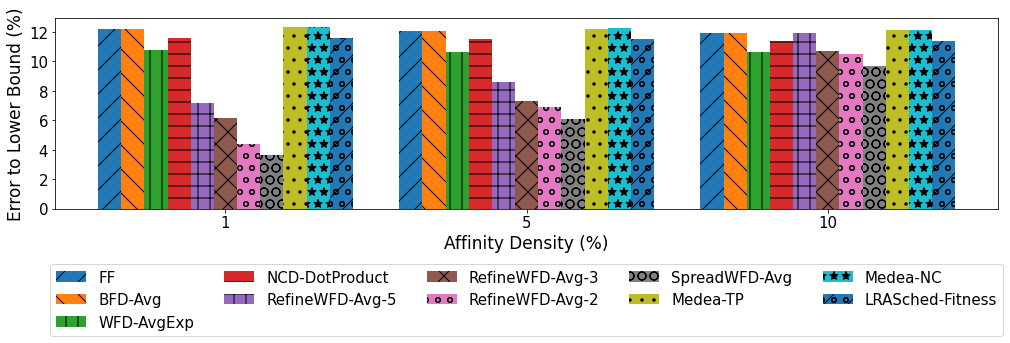

In [41]:
for c in classes: 
# c = "arbitrary"
    fig = plot_barchart(twodim_eps, c, df_2d_column_names_small, "Affinity Density (%)", 'Error to Lower Bound (%)')
    filename = f"{proj_path}/plots/density2D_small_result_{c}.pdf" 
    #fig.savefig(filename)

In [42]:
twodim_time_small

,class,density,FF,BFD-Avg,WFD-AvgExpo,NCD-DotProduct,RefineWFD-Avg-5,RefineWFD-Avg-3,RefineWFD-Avg-2,SpreadWFD-Avg,FFD-Degree,NodeCount,NCD-Fitness
0,arbitrary,1,3.7,4.5,26.3,15.8,64.1,89.7,121.2,225.4,3.7,512.1,13.7
1,arbitrary,5,16.4,17.3,41.4,34.1,181.0,240.0,340.3,652.8,16.2,3200.1,30.3
2,arbitrary,10,32.8,34.4,61.1,62.2,344.6,472.9,622.2,1214.6,32.8,8004.9,55.6
3,normal,1,3.7,4.5,26.0,15.4,64.9,87.4,126.1,233.6,3.6,465.5,13.4
4,normal,5,16.6,17.6,42.0,34.5,200.2,272.2,361.8,684.2,16.5,2674.6,30.9
5,normal,10,30.4,31.3,55.4,54.3,351.6,468.5,657.5,1146.4,30.0,6490.9,49.7
6,threshold,1,3.0,3.8,23.3,12.7,59.0,79.9,118.4,213.7,4.4,137.8,11.6
7,threshold,5,15.3,16.3,38.5,30.3,196.6,266.1,339.4,780.1,31.1,1394.0,27.8
8,threshold,10,29.8,30.7,55.1,49.4,302.3,364.9,412.9,1353.1,85.8,4929.5,46.3


In [43]:
(8004.9+6490.9+4929.5)/3

6475.099999999999

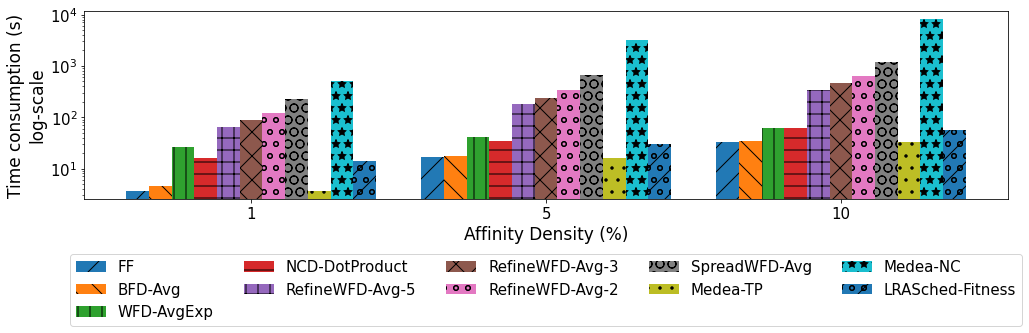

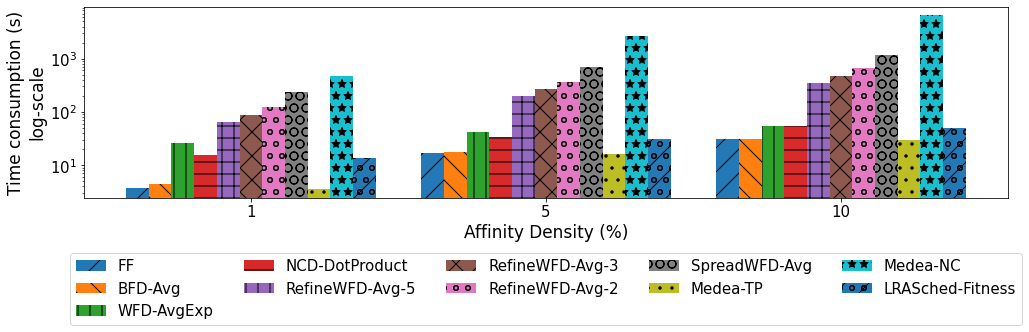

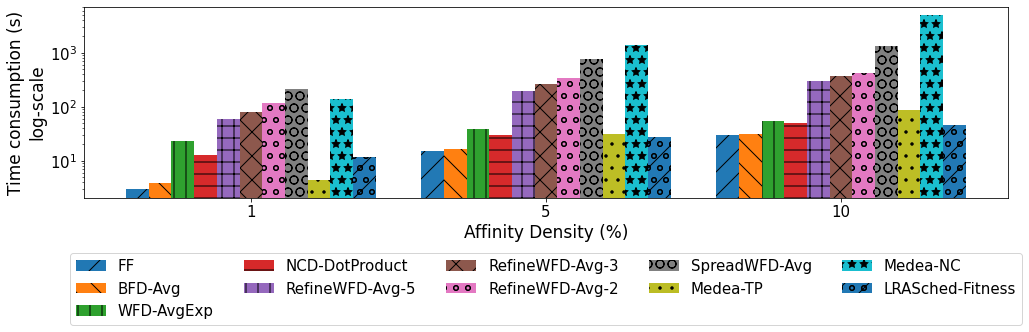

In [45]:
for c in classes: 
    fig = plot_barchart(twodim_time, c, df_2d_column_names_small, "Affinity Density (%)", 'Time consumption (s)\nlog-scale', True)
    filename = f"{proj_path}/plots/density2D_small_time_{c}.pdf" 
    #fig.savefig(filename)

### Test summary plot

Time FF                   17.633333
BFD-Avg              18.733333
WFD-AvgExp           42.933333
NCD-DotProduct       37.366667
RefineWFD-Avg-5     196.566667
RefineWFD-Avg-3     267.533333
RefineWFD-Avg-2     361.233333
SpreadWFD-Avg       697.600000
Medea-TP             17.566667
LRASched-Fitness     33.200000
dtype: float64
Efficiency FF                  12.146667
BFD-Avg             12.146667
WFD-AvgExp          10.713333
NCD-DotProduct      11.496667
RefineWFD-Avg-5      7.136667
RefineWFD-Avg-3      6.136667
RefineWFD-Avg-2      5.393333
SpreadWFD-Avg        4.500000
Medea-TP            12.193333
LRASched-Fitness    11.496667
dtype: float64
['FF', 'BFD-Avg', 'WFD-AvgExp', 'NCD-DotProduct', 'RefineWFD-Avg-5', 'RefineWFD-Avg-3', 'RefineWFD-Avg-2', 'SpreadWFD-Avg', 'Medea-TP', 'LRASched-Fitness']


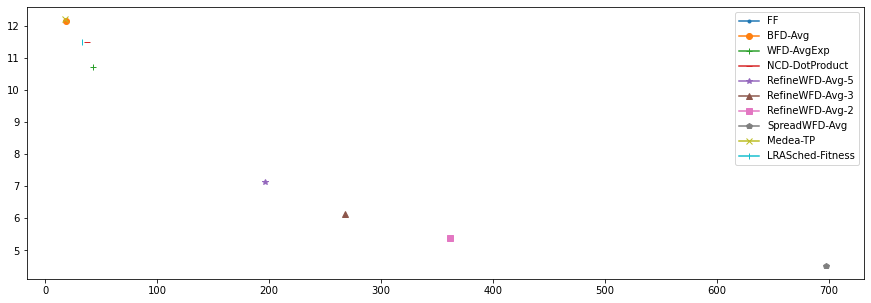

In [94]:
def plot_summary(df_result, df_time, class_name, cols, xlabel, ylabel, log_scale=False):
    df_result = df_result[df_result['class'] == class_name][cols]
    df_result.rename(columns=rename_dict, errors='ignore', inplace=True)
    df_time = df_time[df_time['class'] == class_name][cols]
    df_time.rename(columns=rename_dict, errors='ignore', inplace=True)
    
    df_result.drop('Medea-NC', axis=1, inplace=True)
    df_time.drop('Medea-NC', axis=1, inplace=True)
    
    x = df_time.mean()
    y = df_result.mean()
    
    print("Time", x)
    print("Efficiency", y)
    
    markers = ['.', 'o', '+', '_', '*', '^', 's', 'p', 'x', '|', 'd', '1', '2', '3', '4']
    
    fig = plt.figure(figsize=(15,5))
    algs = list(df_result.T.index)
    #algs.remove('Medea-NC')
    print(algs)
    alg_num = len(algs)
    
    
    
    
    for i in range(alg_num):
        plt.plot(x[i], y[i], marker=markers[i])
    #plt.plot(x, y, 'o')
    
    plt.legend(algs)
    if log_scale:
        plt.xscale('log')
    plt.show()
    return fig
    
fig = plot_summary(twodim_eps_small, twodim_time_small, 'arbitrary', df_2d_column_names_small, "time", "effectiveness", False)
filename = f"{proj_path}/plots/summary_arbitrary.pdf" 
fig.savefig(filename)

In [ ]:
# group of densities/scale
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.2
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
               '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-',
               '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
    
    plt.xticks(x*width_class, labels, fontsize=FONT_SIZE)#,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE)#, fontweight='bold')
    # plt.axhline(1.17*max([max(alg_res[i]) for i in range(alg_num)]), linewidth=0)
    #plt.title((class_name.capitalize() + " graphs"), fontsize=FONT_SIZE, fontname=FONT_NAME)
    plt.xlabel(xlabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE+2)#, fontweight='bold')
    if log_scale:
        plt.yscale('log')
    #plt.legend(algs, loc='upper left', bbox_to_anchor=(-0.07, -0.2), ncol=5, fancybox=True, shadow=False, fontsize=FONT_SIZE)
    plt.legend(algs, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()
    return fig


### Plot effectiveness and time in one

In [ ]:
for c in classes: 
    #c = "arbitrary"
    fig = plot_barchart(twodim_time, c, time_cols_without_nodecount, "Affinity Density (%)", 'Time Consumption (s)')

    filename = f"{proj_path}/plots/density2D_time_{c}.pdf"
    fig.savefig(filename)

In [ ]:
def plot_one(original_df, class_name, cols, ax, labels, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.056
    # labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    ind = np.arange(len(labels))

    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values
    alg_names = tmp_df.columns.tolist()

    width_class = width * (alg_num + 2)
    #width = 0.95/float(alg_num) # 0.06

    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
                '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        if alg_num == 15 and i == 14: # to mute Medea-NC
            ax.bar(ind*width_class, 0, 0)
        ax.bar(ind + i*width - width_class/2,
                alg_res[i], width, hatch=hatches[i], alpha=.99, label=alg_names[i])

    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=FONT_SIZE*.9)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE*.9)
    if log_scale:
        ax.set_yscale('log')

In [ ]:
def plot_barchart_density2D_result_time(data0, data1, filepath):
    labels = ['low density (1%)', 'medium density (5%)',
              'high density (10%)']

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=False)

    plot_one(*data0, axs[0], labels, "Affinity Density",
             'Deviation from Lower Bound (%)')
    plot_one(*data1, axs[1], labels, "Affinity Density",
             'Time Consumption (sec)')

    axs[0].set_yticks(np.arange(0, 20, step=4))
    axs[1].set_yticks(np.arange(0, 80, step=20))
    axs[0].set_yticklabels(np.arange(0, 20, step=4), fontsize=FONT_SIZE)
    axs[1].set_yticklabels(np.arange(0, 80, step=20), fontsize=FONT_SIZE)

    axs[0].set_title(
        '(a) Effectiveness of Different Affinity Densities', fontsize=FONT_SIZE*1.15, y=-.4)
    axs[1].set_title(
        '(b) Time Consumption of Different Affinity Densities', fontsize=FONT_SIZE*1.15, y=-.4)

    fig.legend(
        *(axs[0].get_legend_handles_labels()),
        bbox_to_anchor=(0.5, 1.09),
        loc='upper center',  ncol=4,
        fontsize=FONT_SIZE*0.75, frameon=True)

    plt.subplots_adjust(hspace=0.5)
    plt.savefig(filepath, bbox_inches='tight')


c = "arbitrary"
filename = f"{proj_path}/plots/density2D_result_time_{c}.pdf"
plot_barchart_density2D_result_time(
    (twodim_eps, c, df_2d_column_names),
    (twodim_time, c, time_cols_without_nodecount),
    filename)

## 1.2 Impact of LRA Submission Scale on Effectiveness and Time Consumption 

In [19]:
df_large = pd.read_csv(file_large, sep='\t') ## df_2d_large

twodim_eps_scale, twodim_time_scale = get_scale_exp_results(df_large, df_2d_large_column_names)
twodim_eps_scale.columns = ['class', 'density'] + df_2d_large_column_names
twodim_time_scale.columns = ['class', 'density'] + df_2d_large_column_names

In [20]:
twodim_eps_scale[twodim_eps_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,10000,0.0270,0.0270,0.0270,0.0270,0.0270,0.0339,0.0270,0.0270,0.0270,0.0270,0.0339,0.0260,0.0274,0.0260
1,arbitrary,50000,0.0243,0.0243,0.0243,0.0243,0.0243,0.0381,0.0243,0.0243,0.0244,0.0243,0.0381,0.0234,0.0241,0.0234
2,arbitrary,100000,0.0240,0.0240,0.0240,0.0240,0.0240,0.0378,0.0240,0.0240,0.0241,0.0240,0.0378,0.0232,0.0240,0.0232


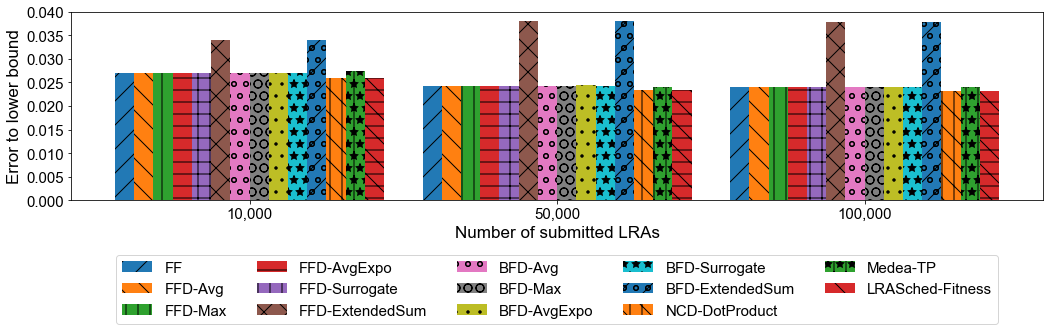

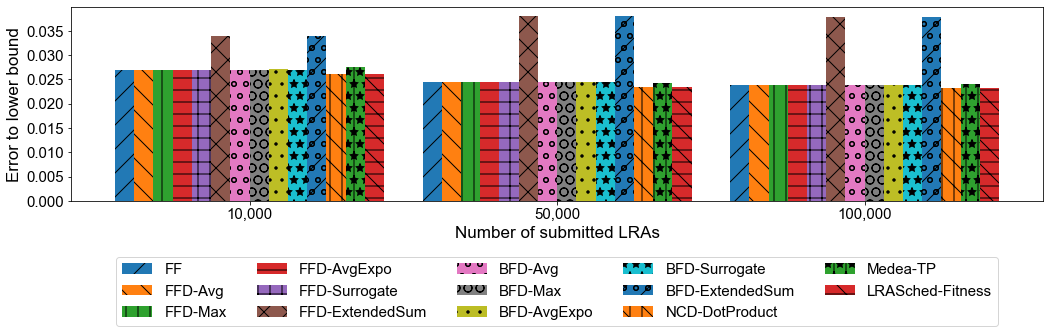

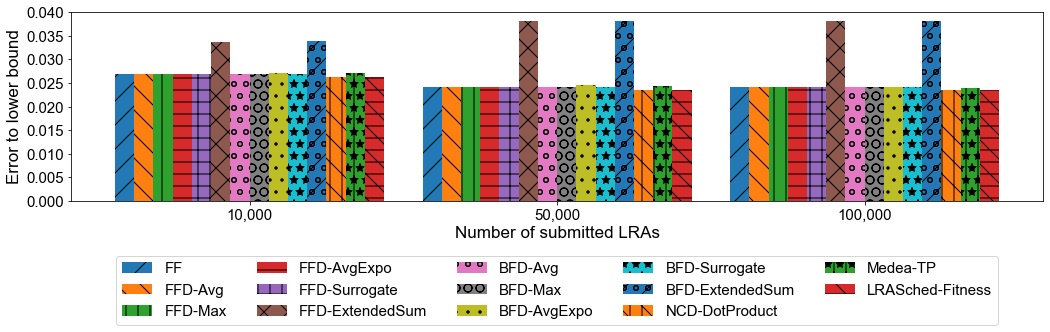

In [21]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(twodim_eps_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                        'Error to lower bound')    
    filename = f"{proj_path}/plots/large2D_result_{c}.pdf" 
    fig.savefig(filename)

In [22]:
twodim_time_scale[twodim_time_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,10000,2.5290,2.5062,2.5043,2.4838,2.4861,3.0249,3.1865,3.1549,3.5625,3.1638,4.44860,14.94220,2.5137,18.39520
1,arbitrary,50000,82.0864,83.4981,84.8444,85.1800,85.8416,130.7033,134.7310,136.3221,159.6201,134.2088,252.25850,974.07300,83.2241,1237.54903
2,arbitrary,100000,325.8789,331.9851,329.6152,331.2620,331.4506,502.9108,513.3166,512.4450,632.2040,517.0758,900.23141,5064.17657,326.8795,6377.53714


In [23]:
twodim_time_scale[twodim_time_scale['class'] == 'threshold'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
6,threshold,10000,2.3146,2.3254,2.3184,2.3176,2.3121,2.7616,2.9147,2.9072,3.2960,2.9273,4.0359,12.70400,2.4497,15.52120
7,threshold,50000,61.1581,61.9257,61.7976,61.9833,60.3730,76.8674,90.0752,92.2938,109.5791,91.2435,155.2414,575.76020,67.4533,746.80330
8,threshold,100000,285.0328,281.0873,285.8988,285.0730,301.5077,397.8892,446.4992,441.0202,541.9529,432.7395,686.2282,2988.26279,327.0683,3902.85819


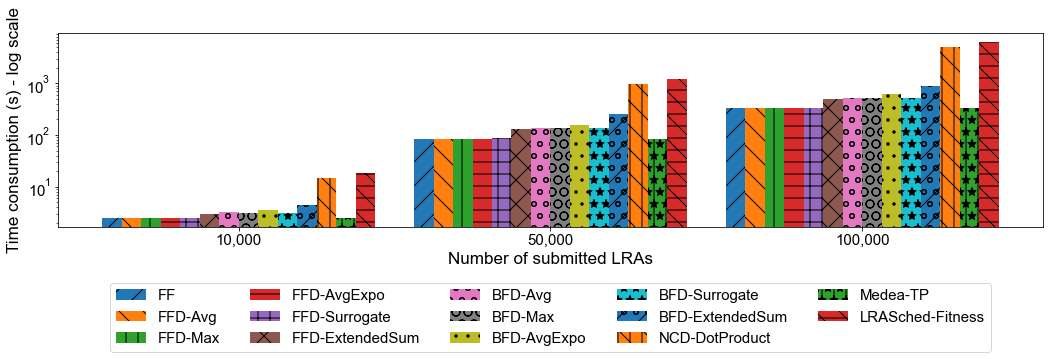

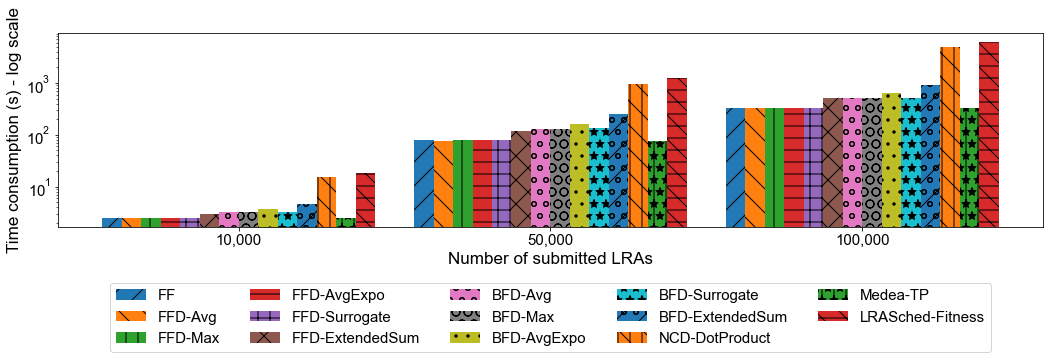

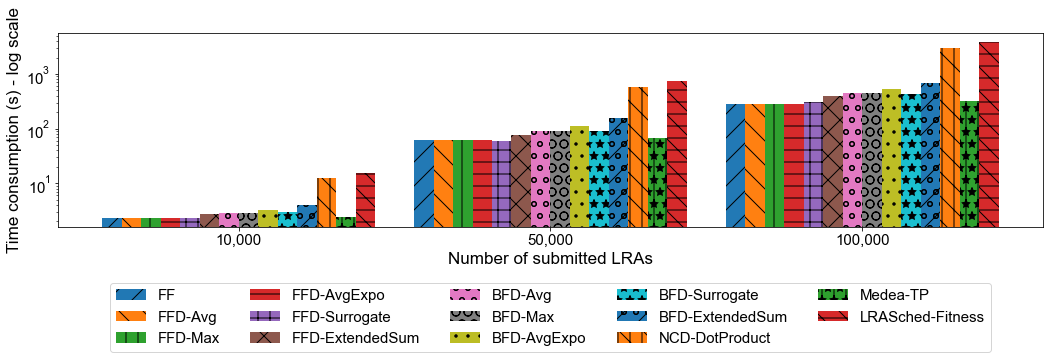

In [24]:
for c in classes: 
#c = "arbitrary"
#fig = plot_scale_barchart(twodim_time_scale, c, df_2d_large_column_names, 'Time consumption (s)')
    fig = plot_barchart(twodim_time_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/large2D_time_{c}.pdf" 
    fig.savefig(filename)

# Result-2: Time-Varying Res Request

In [48]:
df_ts = pd.read_csv(file_ts, sep='\t')
ts_eps, ts_time = get_exp_results(df_ts, df_ts_column_names)
ts_eps.columns = ['class', 'density'] + df_ts_column_names
ts_time.columns = ['class', 'density'] + df_ts_column_names

## 2.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [49]:
ts_eps#.sort_values(by='density')

,class,density,FF,BFD-Avg,WFD-AvgExpo,SpreadWFD-Avg,FFD-Degree
0,arbitrary,1,10.42,9.18,8.66,2.43,10.05
1,arbitrary,5,10.25,9.21,8.82,2.63,9.93
2,arbitrary,10,10.04,9.44,9.17,3.03,9.91
3,normal,1,10.43,9.20,8.69,2.10,10.12
4,normal,5,10.27,9.24,8.82,2.62,9.89
5,normal,10,10.08,9.49,9.27,3.87,9.78
6,threshold,1,10.41,9.28,8.74,2.21,10.23
7,threshold,5,10.26,9.64,9.12,7.11,10.06
8,threshold,10,10.13,10.06,9.70,28.42,9.92


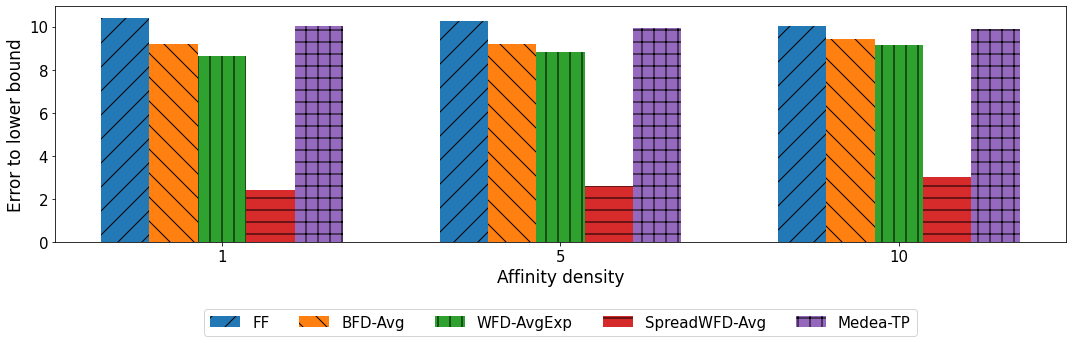

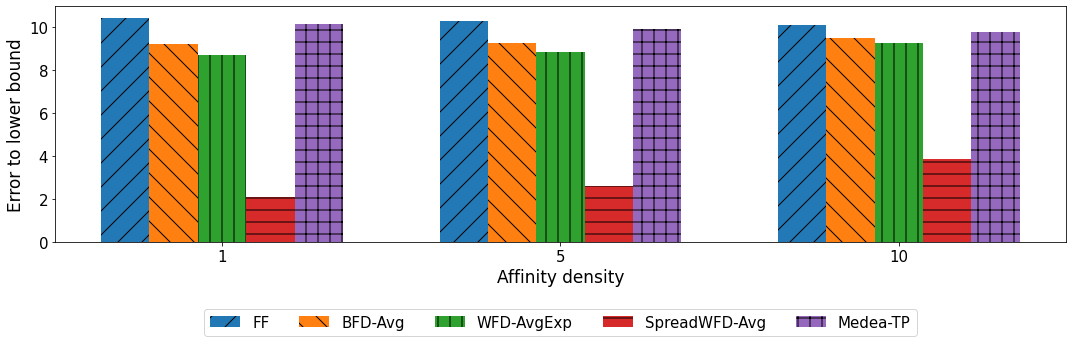

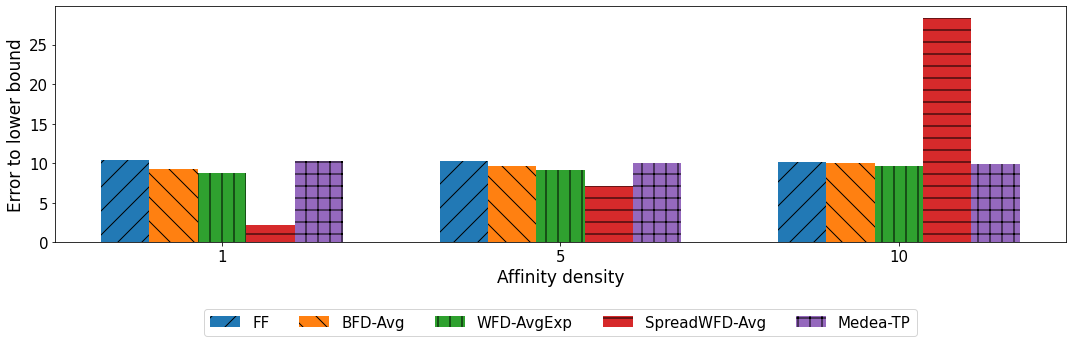

In [51]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_eps, c, df_ts_column_names, "Affinity density", 'Error to lower bound')

    filename = f"{proj_path}/plots/densityTS_result_{c}.pdf" 
    #fig.savefig(filename)

In [52]:
ts_time#.sort_values(by='density')

,class,density,FF,BFD-Avg,WFD-AvgExpo,SpreadWFD-Avg,FFD-Degree
0,arbitrary,1,7.4,11.1,171.5,252.5,7.2
1,arbitrary,5,22.0,27.5,240.9,595.8,21.9
2,arbitrary,10,38.5,44.5,239.6,1124.7,38.2
3,normal,1,9.0,13.0,182.8,250.6,8.5
4,normal,5,23.3,29.9,255.0,619.3,22.3
5,normal,10,39.0,45.2,247.5,1134.9,38.9
6,threshold,1,8.3,12.4,170.2,218.2,9.2
7,threshold,5,21.4,27.0,228.7,535.5,38.2
8,threshold,10,37.4,42.9,239.8,1989.8,97.6


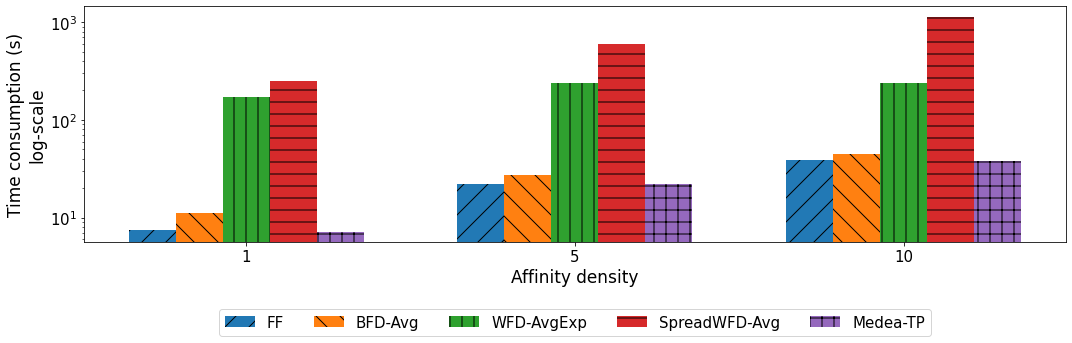

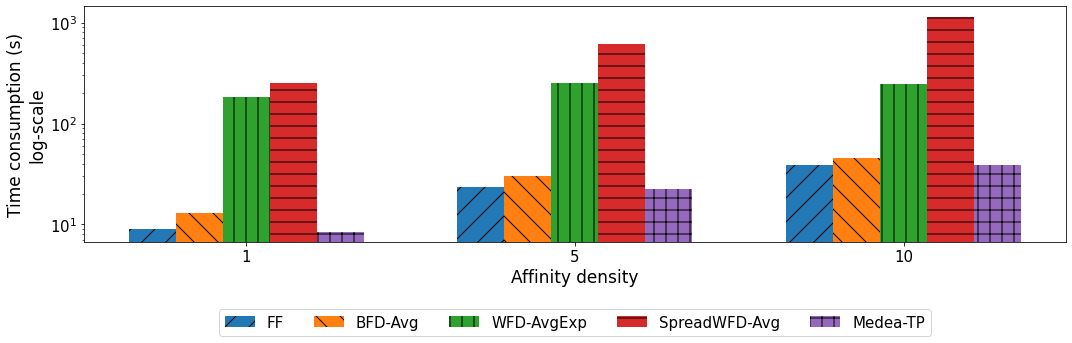

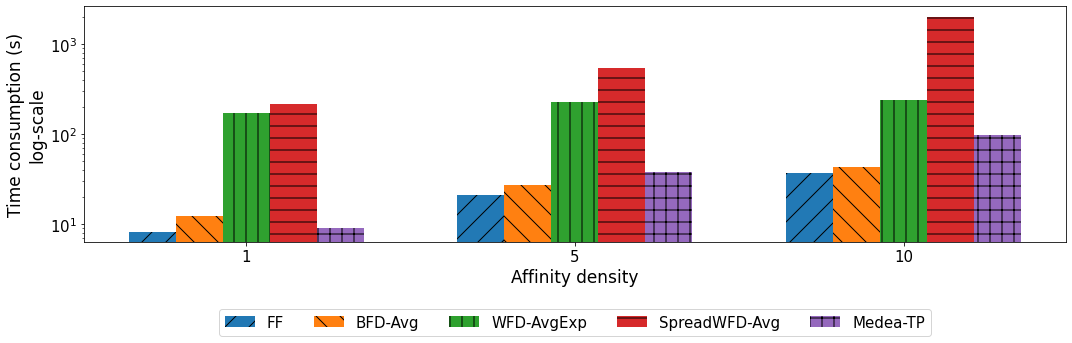

In [54]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_time, c, df_ts_column_names, "Affinity density", 'Time consumption (s)\nlog-scale', True)

    filename = f"{proj_path}/plots/densityTS_time_{c}.pdf" 
    fig.savefig(filename)

## 2.2 Impact of LRA Submission Scale On Effectiveness and Time Consumption

In [30]:
df_large_ts = pd.read_csv(file_largeTS, sep='\t') ## df_TS_large

ts_eps_scale, ts_time_scale = get_scale_exp_results(df_large_ts, df_ts_large_column_names)
ts_eps_scale.columns = ['class', 'density'] + df_ts_large_column_names
ts_time_scale.columns = ['class', 'density'] + df_ts_large_column_names

In [31]:
ts_eps_scale[ts_eps_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,0.0535,0.0484,0.0486,0.0534
1,arbitrary,50000,0.0593,0.0569,0.0566,0.0596
2,arbitrary,100000,0.0611,0.0593,0.0593,0.0610


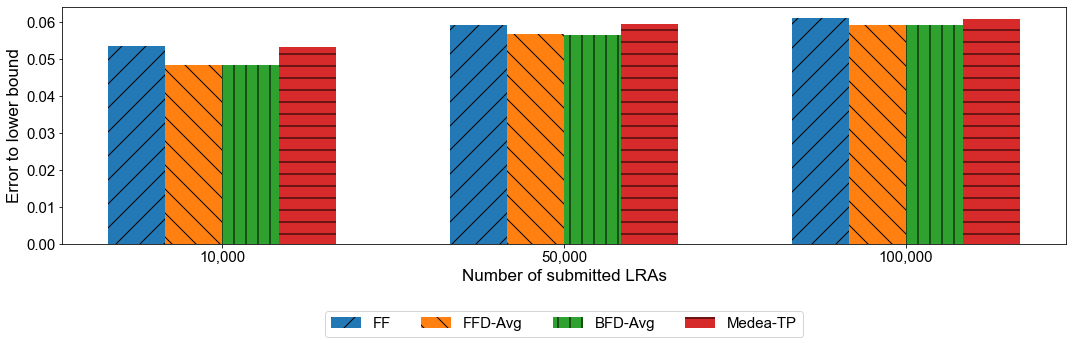

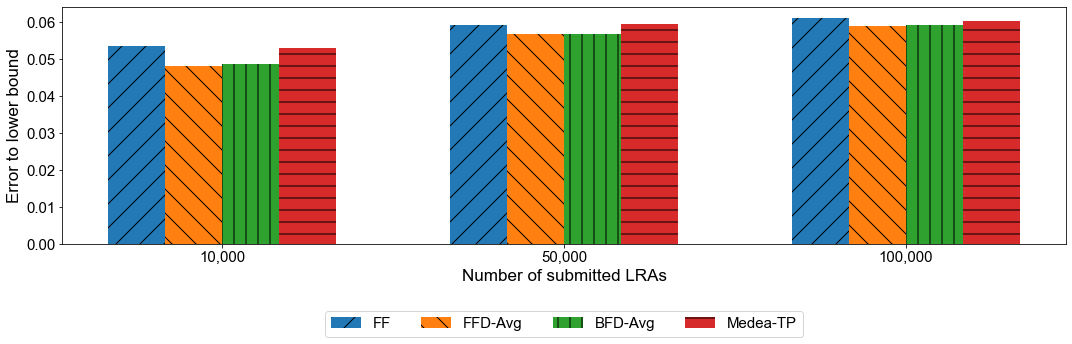

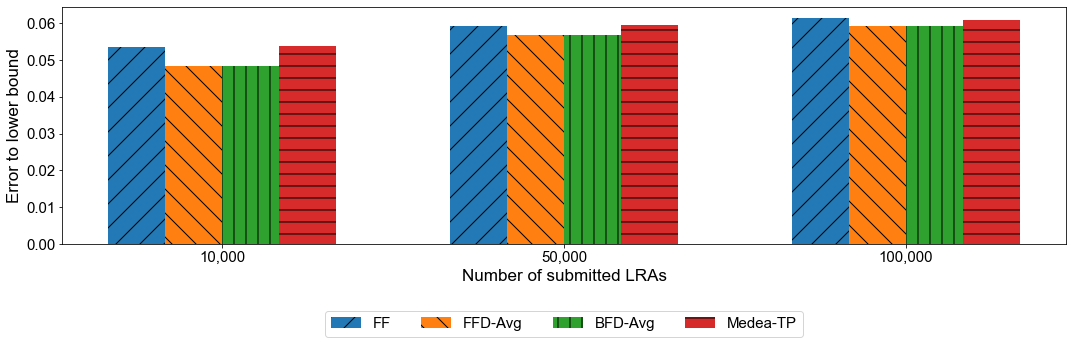

In [32]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_eps_scale, c, df_ts_large_column_names, "Number of submitted LRAs", 'Error to lower bound')    
    filename = f"{proj_path}/plots/largeTS_result_{c}.pdf" 
    fig.savefig(filename)

In [33]:
ts_time_scale[ts_time_scale['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,5.4079,5.4637,6.1670,5.27680
1,arbitrary,50000,212.9288,228.2361,268.6106,215.57380
2,arbitrary,100000,963.0881,1035.4934,1286.4603,965.86741


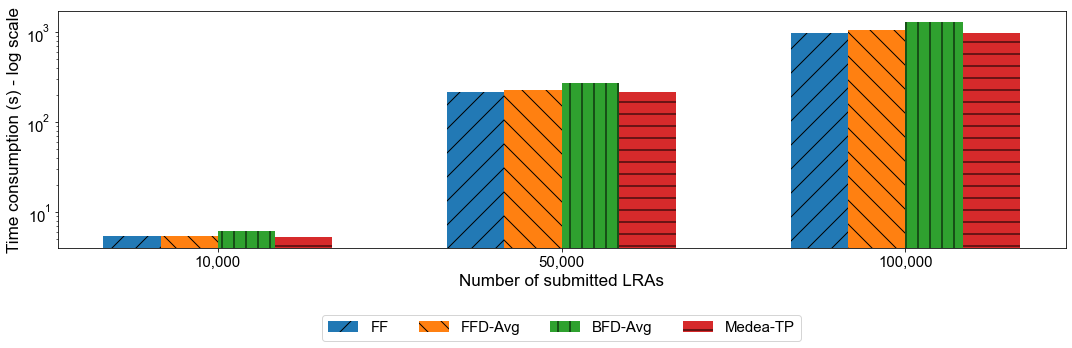

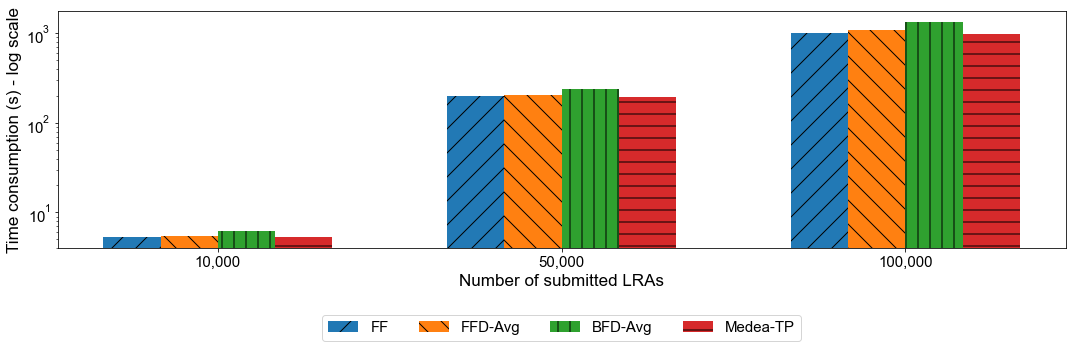

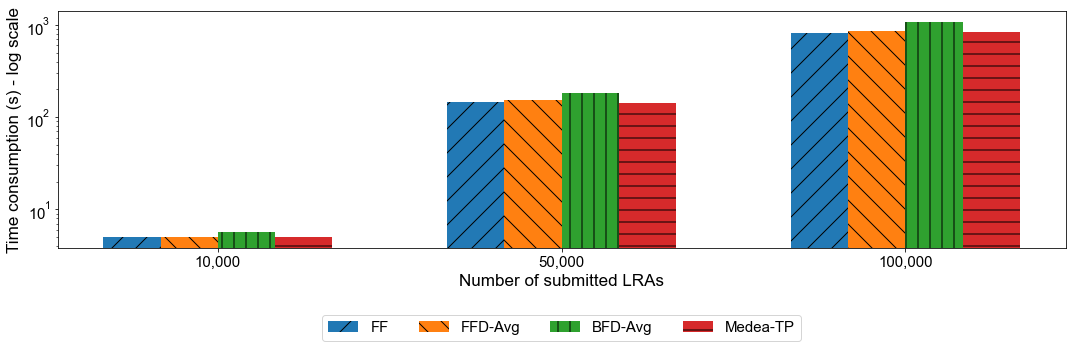

In [34]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(ts_time_scale, c, df_ts_large_column_names, "Number of submitted LRAs",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/largeTS_time_{c}.pdf" 
    fig.savefig(filename)

# Result-3: Scalability with Varying Res Request

In [35]:
def get_scalability_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[2])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    df_eps = sub_df[['class', 'LRAnum'] + epsilon_column_names]
    df_time = sub_df[['class', 'LRAnum'] + time_column_names]
    return df_eps, df_time

In [36]:
df_scalab = pd.read_csv(file_scalabilityTS, sep='\t')
scalab_eps, scalab_time = get_scalability_exp_results(df_scalab, df_scalab_column_names)
scalab_eps.columns = ['class', 'density'] + df_scalab_column_names
scalab_time.columns = ['class', 'density'] + df_scalab_column_names

In [37]:
scalab_eps[df_scalab_column_names] *= 100

scalab_eps[scalab_eps['class'] == 'arbitrary'].sort_values(by='density')


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,5.6,5.4,5.4,5.5
3,arbitrary,20000,6.5,6.1,6.0,6.1
6,arbitrary,30000,5.8,5.2,5.2,5.8
9,arbitrary,40000,6.2,5.8,5.8,6.8
12,arbitrary,50000,5.9,5.6,5.6,5.8
15,arbitrary,60000,5.6,5.2,5.2,5.6
18,arbitrary,70000,6.1,5.9,6.0,6.1
21,arbitrary,80000,5.9,5.5,5.5,5.9
24,arbitrary,90000,5.6,5.5,5.5,5.7
27,arbitrary,100000,5.9,5.9,5.9,5.9


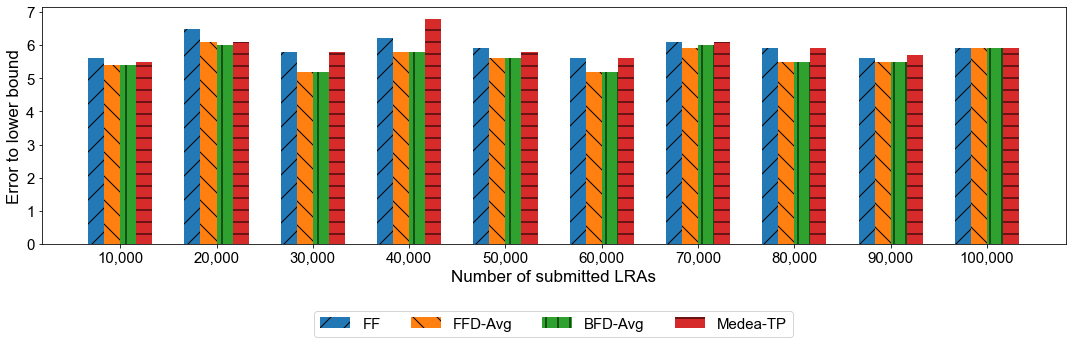

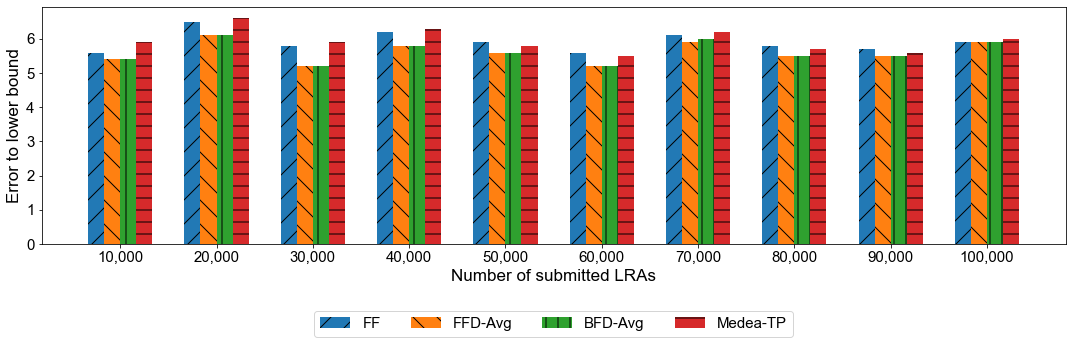

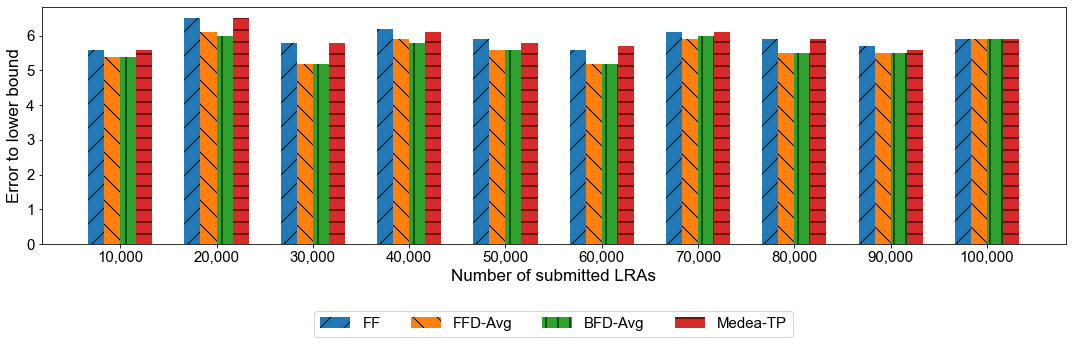

In [38]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(scalab_eps, c, df_scalab_column_names, "Number of submitted LRAs", 'Error to lower bound')    
    filename = f"{proj_path}/plots/scalabilityTS_result_{c}.pdf" 
    fig.savefig(filename)

In [39]:
scalab_time[scalab_time['class'] == 'arbitrary'].sort_values(by='density')


,class,density,FF,FFD-Avg,BFD-Avg,FFD-Degree
0,arbitrary,10000,4.243,9.725,12.366,4.556
3,arbitrary,20000,60.612,60.125,68.598,60.182
6,arbitrary,30000,97.086,97.589,113.608,96.306
9,arbitrary,40000,187.225,187.978,221.180,179.219
12,arbitrary,50000,275.805,277.453,328.986,272.970
15,arbitrary,60000,390.853,400.911,479.626,388.166
18,arbitrary,70000,557.904,572.322,689.591,567.453
21,arbitrary,80000,737.540,733.013,889.931,732.867
24,arbitrary,90000,887.948,891.088,1090.752,871.906
27,arbitrary,100000,1114.787,1146.088,1386.874,1111.071


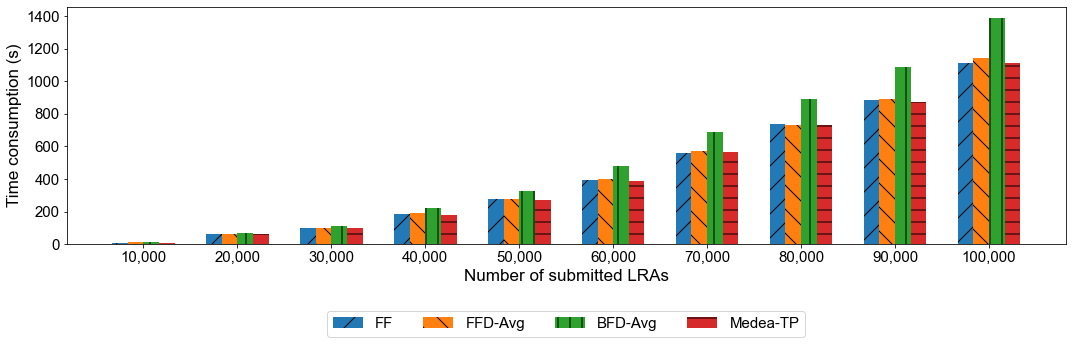

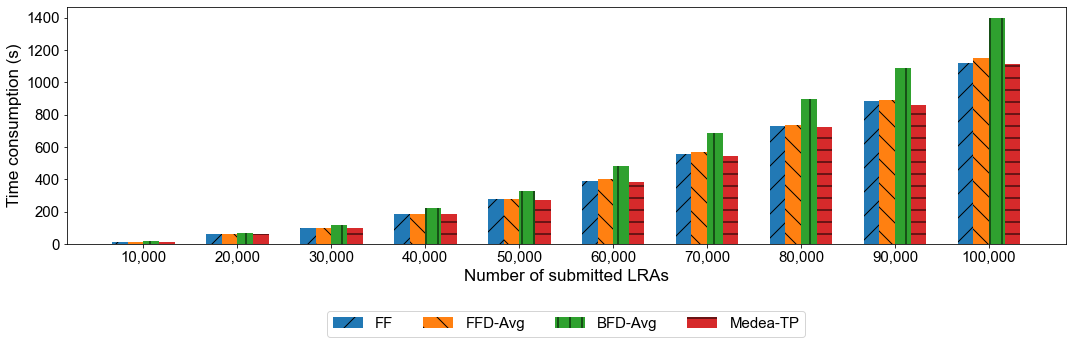

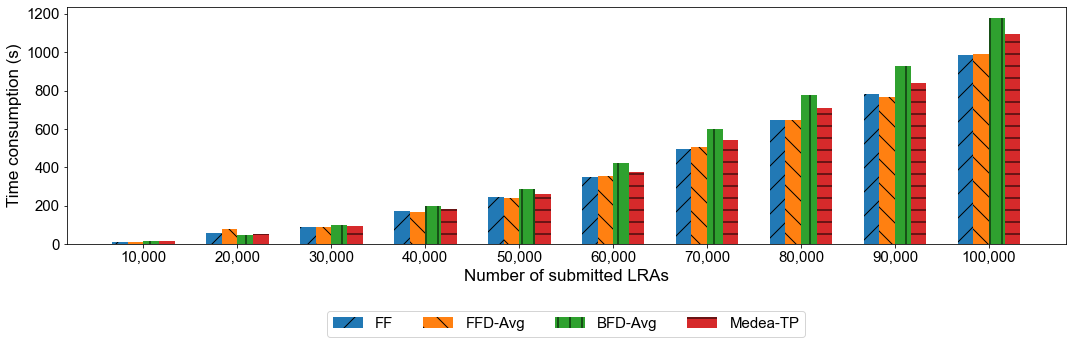

In [40]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(scalab_time, c, df_scalab_column_names, "Number of submitted LRAs", 'Time consumption (s)')

    filename = f"{proj_path}/plots/scalabilityTS_time_{c}.pdf" 
    fig.savefig(filename)

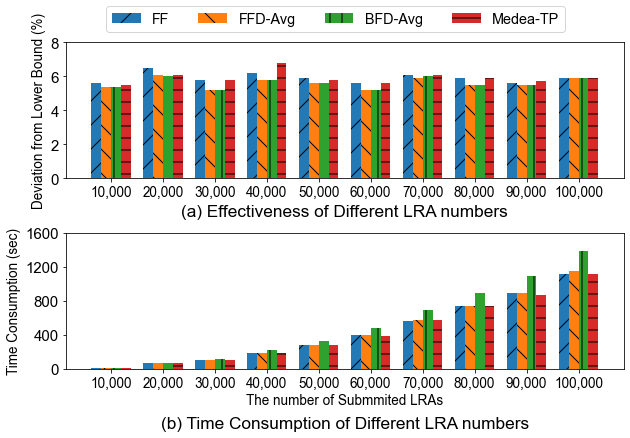

In [41]:
def _plot_one(original_df, class_name, cols, ax, labels, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.19
    ind = np.arange(len(labels))

    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values
    alg_names = tmp_df.columns.tolist()

    width_class = width * (alg_num + 2)
    #width = 0.95/float(alg_num) # 0.06

    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
               '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        ax.bar(ind + i*width - width_class/4,
               alg_res[i], width, hatch=hatches[i], alpha=.99, label=alg_names[i])

    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=FONT_SIZE*.9)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE*.9)
    if log_scale:
        ax.set_yscale('log')

def plot_barchart_scalabilityTS_result_time(data0, data1, filepath):
    labels = [f'{i},000' for i in range(10, 110, 10)]
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=False)

    xlabel = "The Number of Submitted LRAs"
    _plot_one(*data0, axs[0], labels, xlabel,
             'Deviation from Lower Bound (%)')
    _plot_one(*data1, axs[1], labels, xlabel,
             'Time Consumption (sec)')

    axs[0].set_yticks(np.arange(0, 9, step=2))
    axs[1].set_yticks(np.arange(0, 1700, step=400))
    axs[0].set_yticklabels(np.arange(0, 9, step=2), fontsize=FONT_SIZE)
    axs[1].set_yticklabels(np.arange(0, 1700, step=400), fontsize=FONT_SIZE)

    axs[0].set_title(
        '(a) Effectiveness of Different LRA Numbers', fontsize=FONT_SIZE*1.15, y=-.32)
    axs[1].set_title(
        '(b) Time Consumption of Different LRA Numbers', fontsize=FONT_SIZE*1.15, y=-.48)
    
    #axs[0].set_xlabel(xlabel, fontsize=FONT_SIZE*.9, loc='center')
    axs[1].set_xlabel(xlabel, fontsize=FONT_SIZE*.9, loc='center')

    fig.legend(
        *(axs[0].get_legend_handles_labels()),
        bbox_to_anchor=(0.5, .98),
        loc='upper center',  ncol=4,
        fontsize=FONT_SIZE*.96, frameon=True)

    plt.subplots_adjust(hspace=0.4)
    plt.savefig(filepath, bbox_inches='tight')


c = "arbitrary"
filename = f"{proj_path}/plots/scalabilityTS_result_time_{c}.pdf"

plot_barchart_scalabilityTS_result_time(    
    (scalab_eps, c, df_scalab_column_names),
    (scalab_time, c, df_scalab_column_names),
    filename)
    

# Result-4: Scheduling per Batch with Varying Res Request

In [42]:
df_batch = pd.read_csv(file_batchTS, sep='\t')
batch_eps, batch_time = get_exp_results(df_batch, df_batch_column_names)
batch_eps.columns = ['class', 'density'] + df_batch_column_names
batch_time.columns = ['class', 'density'] + df_batch_column_names

In [43]:
batch_eps[batch_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,1,0.1042,0.1211,0.1213,0.1377,0.1024,0.1366
1,arbitrary,5,0.1025,0.1196,0.1201,0.1496,0.1005,0.1488
2,arbitrary,10,0.1004,0.1178,0.1188,0.1599,0.0995,0.1605


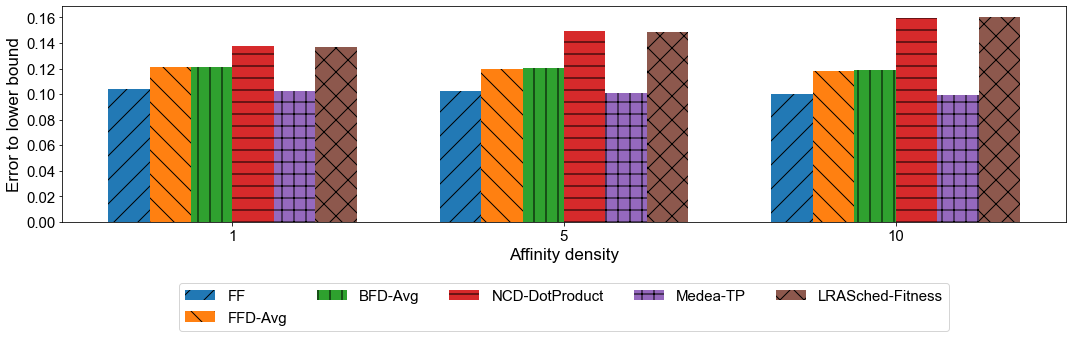

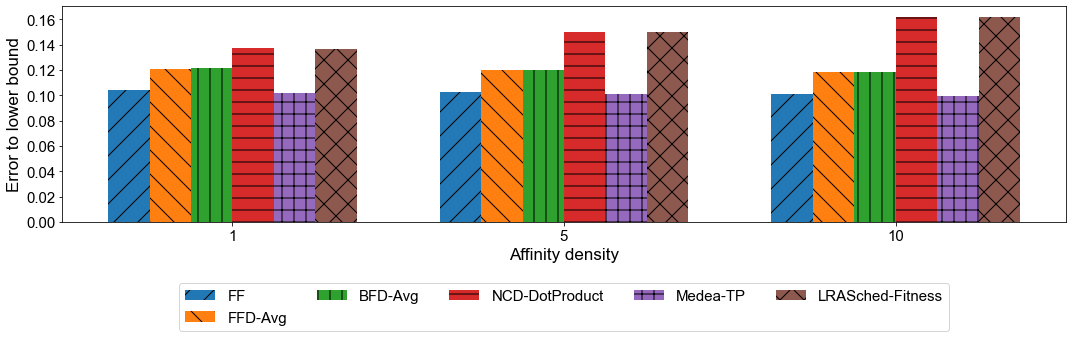

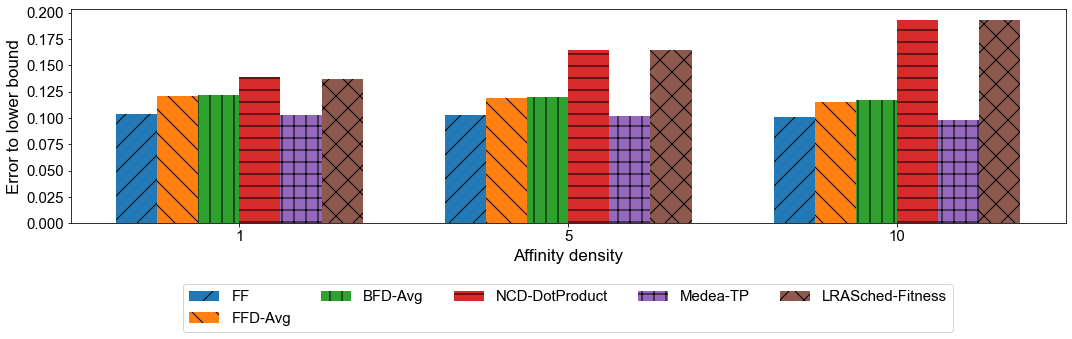

In [44]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(batch_eps, c, df_batch_column_names, "Affinity density", 'Error to lower bound')

    filename = f"{proj_path}/plots/batchTS_result_{c}.pdf" 
    fig.savefig(filename)

In [45]:
batch_time[batch_time['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,BFD-Avg,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,1,15.1146,15.2852,18.7373,18.0680,14.8943,933.0828
1,arbitrary,5,31.1402,31.2529,33.3123,31.3635,30.8672,980.3766
2,arbitrary,10,56.0929,56.6181,54.7653,58.1965,55.0989,1038.7130


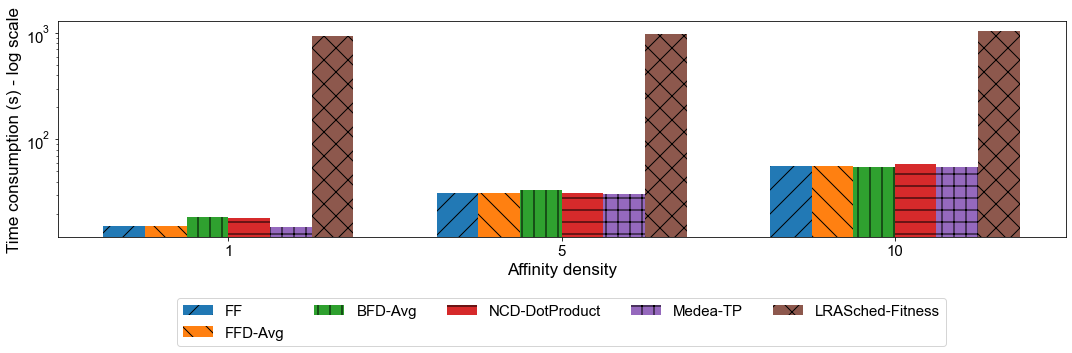

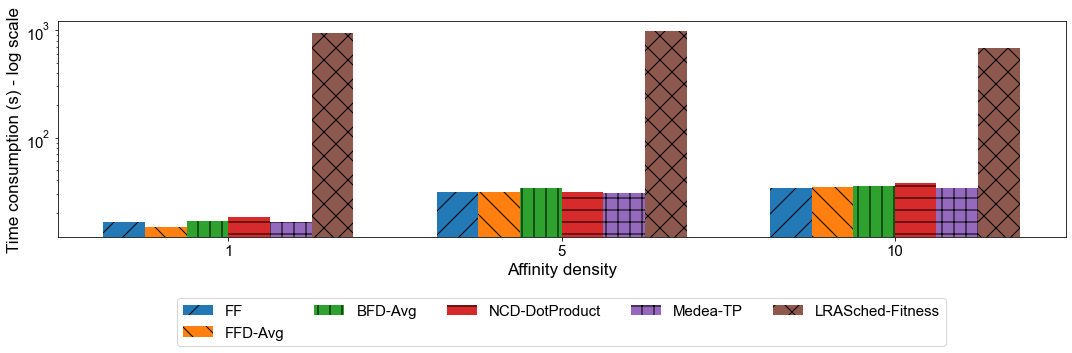

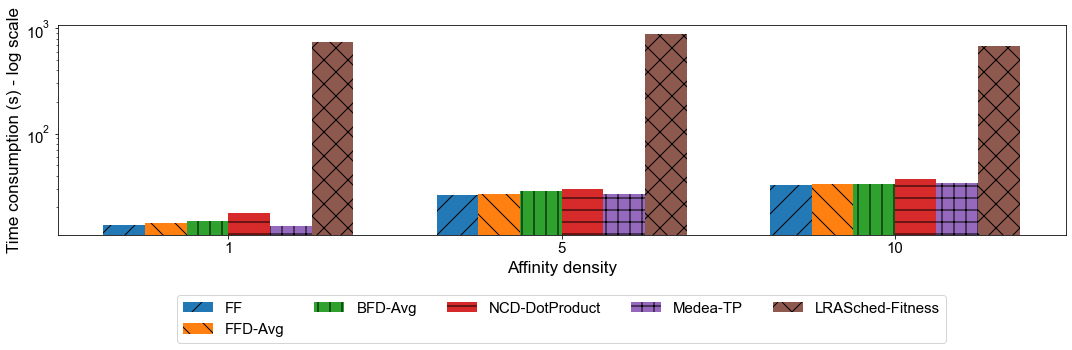

In [46]:
for c in classes: 
#c = "arbitrary"
    fig = plot_barchart(batch_time, c, df_batch_column_names, "Affinity density",
                        'Time consumption (s) - log scale', True)

    filename = f"{proj_path}/plots/batchTS_time_{c}.pdf" 
    fig.savefig(filename)